# Week 1

> Wednesday 28.03.18 - v. 0.1

* **Pre-Training**: `tangency-portfolio`
* **Market Simulation**: baseline models
* **Environment**: observation & OpenAI new API

## Risk Averse Portfolio with Transaction Costs

Determine portfolio vector $\mathbf{w}$, such that:

\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \mathbf{w}^{T} \mathbf{r} -
    \alpha \mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w} -
    \mathbf{1}^{T} (\mathbf{w_{0}} - \mathbf{w}) \\
& \text{subject to}
& & \mathbf{w}^{T} \mathbf{1} = 1 \\
&
& & 
\end{aligned}

where:

* $M$: number of assets in portfolio
* $\alpha \geq 0$: risk-aversion coefficient
* $\boldsymbol{\Sigma} \in \mathbb{R}^{M \times M}$: portfolio returns covariance
* $\mathbf{r} \in \mathbb{R}^{M}$: portfolio returns mean
* $\mathbf{w_{0}}$: initial portfolio weights

In [1]:
import datetime

import numpy as np
import scipy

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import ConvLSTM2D

from statsmodels.tsa.api import VAR
import statsmodels.tsa.vector_ar.util as var_util

import pandas_datareader.data as web
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-muted')
plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/alpha/Developer/qtrader/.env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Source

In [2]:
# one-year window
start_date = datetime.date.today() - datetime.timedelta(days=3*365)

# stock tickers
TICKERS = ['AAPL', 'GE', 'JPM', 'GOOG', 'MSFT', 'VOD', 'GS', 'TSLA']

# prices
prices = pd.DataFrame(columns=TICKERS)

for ticker in TICKERS:
    try:
        # fetch Adjusted Close Price
        prices[ticker] = web.DataReader(ticker, 'quandl', start=start_date)['AdjClose']
    except Exception:
        # exception
        print('[%s] failed to download!' % ticker)
        prices.drop(columns=[ticker], inplace=True)

# sort ascending date
prices.sort_index(ascending=True, inplace=True)

# returns
returns = prices.pct_change(20).dropna()
# log-returns
rhos = np.log(1 + returns)

### Empirical Estimators

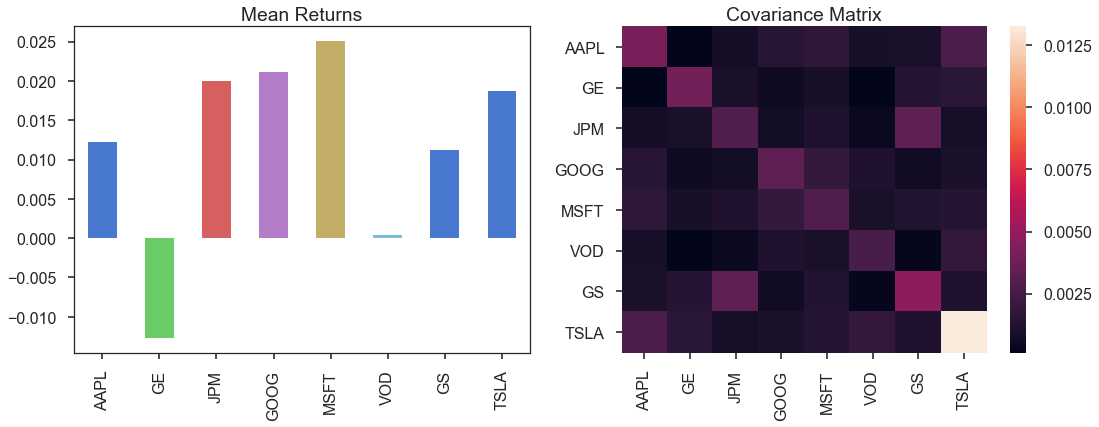

In [3]:
# mean returns
mu_r = returns.mean()
# returns covariance
Sigma_r = returns.cov()

fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))

mu_r.plot.bar(ax=axes[0])
axes[0].set_title('Mean Returns')

sns.heatmap(Sigma_r, ax=axes[1])
axes[1].set_title('Covariance Matrix');

### Optimizer

In [4]:
def mu_p(w, r):
    """Portfolio Returns."""
    return np.dot(w.T, r)

def sigma_p(w, Sigma):
    """Portoflio Variance"""
    return np.dot(np.dot(w.T, Sigma), w)

def trans_costs(w, w0, beta):
    """Transaction Costs."""
    return np.sum(np.abs(w0 - w)) * beta

def J(w, mu, Sigma, alpha, w0, beta):
    """Objective function."""
    assert Sigma.shape[0] == Sigma.shape[1]
    assert mu.shape[0] == Sigma.shape[0]
    assert w.shape == w0.shape
    # mean - alpha * variance - transaction_costs 
    return - (mu_p(w, mu) - alpha * sigma_p(w, Sigma) - trans_costs(w, w0, beta))

def optimizer(mu, Sigma, alpha, w0, beta, short_sales=True):
    """Risk Aversion Portfolio with
    Transaction Costs."""
    # number of assets
    M = mu.shape[0]
    # equality constraint: budget
    con_budget = {
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1.0
    }
    if short_sales:
        bounds = [(0, None) for _ in range(M)]
    else:
        bounds = [(None, None) for _ in range(M)]
    # execute
    results = scipy.optimize.minimize(
        J, w0, (mu, Sigma, alpha, w0, beta),
        constraints=(con_budget),
        bounds=bounds,
        method='SLSQP'
    )
    # handle errors
    if not results.success:
        raise BaseException(results.message)
    # optimal portfolio weights
    w = results.x
    return w, (mu_p(w, mu),
               sigma_p(w, Sigma),
               trans_costs(w, w0, beta))

### Experiments

In [5]:
# uniform initial weights
w0 = np.ones_like(mu_r) / len(mu_r)

# range of alpha
alphas = np.linspace(0.001, 1000, 1000)

# caches
mus = np.empty_like(alphas)
sigmas = np.empty_like(alphas)
trans = np.empty_like(alphas)

# run experiments
for j, alpha in enumerate(alphas):
    _, (mus[j], sigmas[j], trans[j]) = optimizer(mu_r, Sigma_r, alpha, w0, 0.0025)

In [6]:
np.sqrt(sigmas).shape

(1000,)

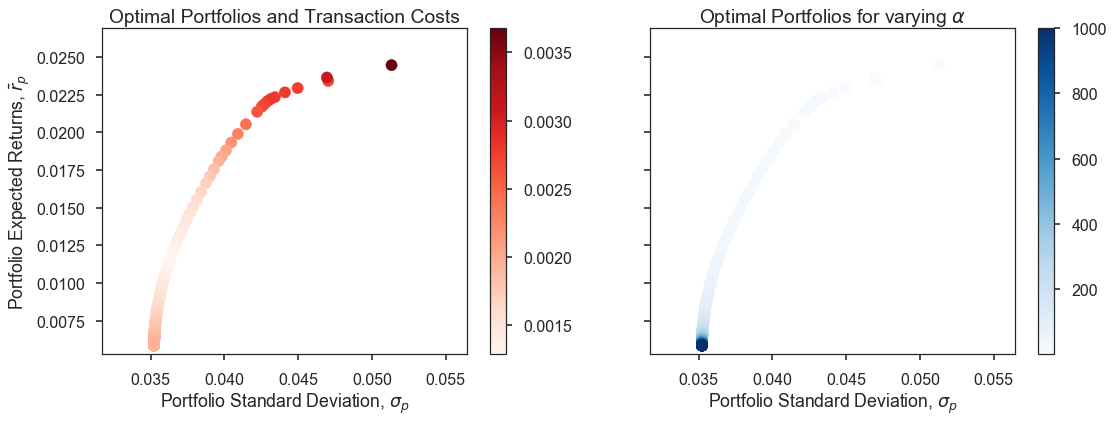

In [7]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(18.0, 6.0))
sc0 = axes[0].scatter(np.sqrt(sigmas), mus, c=trans, cmap=plt.cm.Reds)

axes[0].set_title('Optimal Portfolios and Transaction Costs')
axes[0].set_xlabel('Portfolio Standard Deviation, $\\sigma_{p}$')
axes[0].set_ylabel('Portfolio Expected Returns, $\\bar{r}_{p}$')
axes[0].set_ylim([mus.min() * 0.9, mus.max() * 1.1])
axes[0].set_xlim([np.sqrt(sigmas).min() * 0.9, np.sqrt(sigmas).max() * 1.1])
fig.colorbar(sc0, ax=axes[0])

sc1 = axes[1].scatter(np.sqrt(sigmas), mus, c=alphas, cmap=plt.cm.Blues)
axes[1].set_title('Optimal Portfolios for varying $\\alpha$')
axes[1].set_xlabel('Portfolio Standard Deviation, $\\sigma_{p}$')
axes[1].set_ylim([mus.min() * 0.9, mus.max() * 1.1])
axes[1].set_xlim([np.sqrt(sigmas).min() * 0.9, np.sqrt(sigmas).max() * 1.1])
fig.colorbar(sc1, ax=axes[1]);

### Agent

## Market Simulation: Baseline Models

### Surrogates: Amplitude Adjusted Fourier Transform (AAFT)

Preserve first and second order statistical moments by:

1. Fourier Transformation of multivariate time-series
2. Randomisation of Phase
3. Inverse Fourier Transaformation

The identity of the autocorrelation functions is based on the fact that the original time series and the surrogate
have per construction the same power spectrum, which in turn is linked to the autocorrelation function via the
[Wiener–Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem).

In [8]:
def AAFT(ts, random=np.random.uniform, random_state=None):
    """Amplitude Adjusted Fourier Transform."""
    # set random seed
    np.random.seed(random_state)
    # 2d time-series format
    _ts = ts.reshape(len(ts), -1)
    # Odd number of samples
    if len(_ts) % 2 != 0:
        _ts = _ts[1:, :]
    # Generated time-series
    ts_gen = np.empty_like(_ts)
    for i, tsi in enumerate(_ts.T):
        # Fourier Transaformation (real-valued signal)
        F_tsi = np.fft.rfft(tsi)
        # Randomisation of Phase
        rv_phase = np.exp(random(0, np.pi, len(F_tsi)) * 1.0j)
        # Generation of new time-series
        F_tsi_new = F_tsi * rv_phase
        # Inverse Fourier Transformation
        ts_gen[:, i] = np.fft.irfft(F_tsi_new)
    return ts_gen

#### Experiments

In [9]:
# prices time-series generation
prices_gen = AAFT(prices.dropna().values, random=np.random.normal, random_state=13)

# returns time-series generation
returns_gen = AAFT(returns.dropna().values, random=np.random.normal, random_state=13)

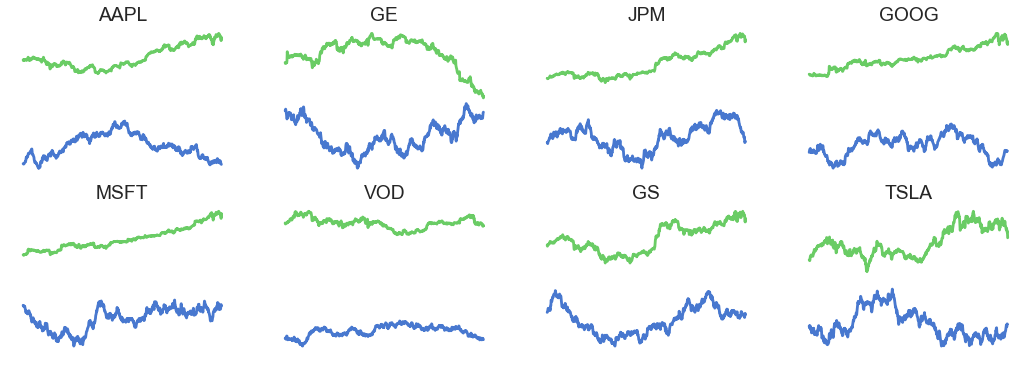

In [10]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(prices.shape[1] / 2), figsize=(18.0, 6.0))
for j, (ax, ts) in enumerate(zip(axes.flatten(), prices_gen.T)):
    ax.plot(ts, label="AAFT")
    ax.plot(prices.values[:, j], label="Original")
    ax.set_title(prices.columns[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

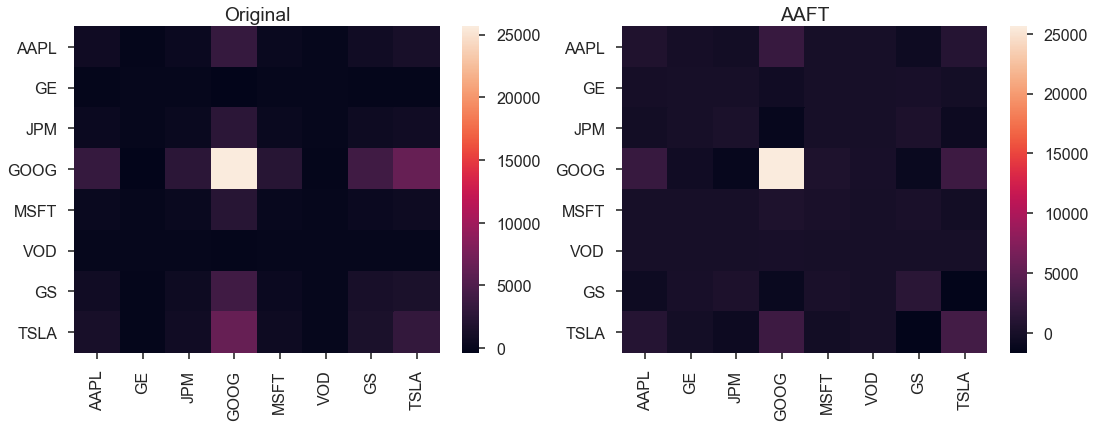

In [11]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(np.cov(prices.values.T), ax=axes[0])
axes[0].set_title("Original")
axes[0].set_xticklabels(prices.columns, rotation=90)
axes[0].set_yticklabels(prices.columns, rotation=0)
sns.heatmap(np.cov(prices_gen.T), ax=axes[1])
axes[1].set_title("AAFT")
axes[1].set_xticklabels(prices.columns, rotation=90)
axes[1].set_yticklabels(prices.columns, rotation=0);

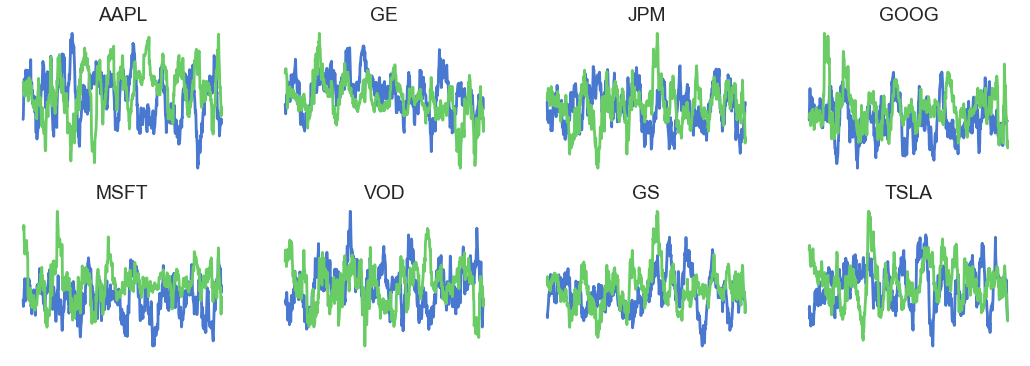

In [12]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(returns.shape[1] / 2), figsize=(18.0, 6.0))
for j, (ax, ts) in enumerate(zip(axes.flatten(), returns_gen.T)):
    ax.plot(ts, label="VAR")
    ax.plot(returns.values[:, j], label="Original")
    ax.set_title(returns.columns[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

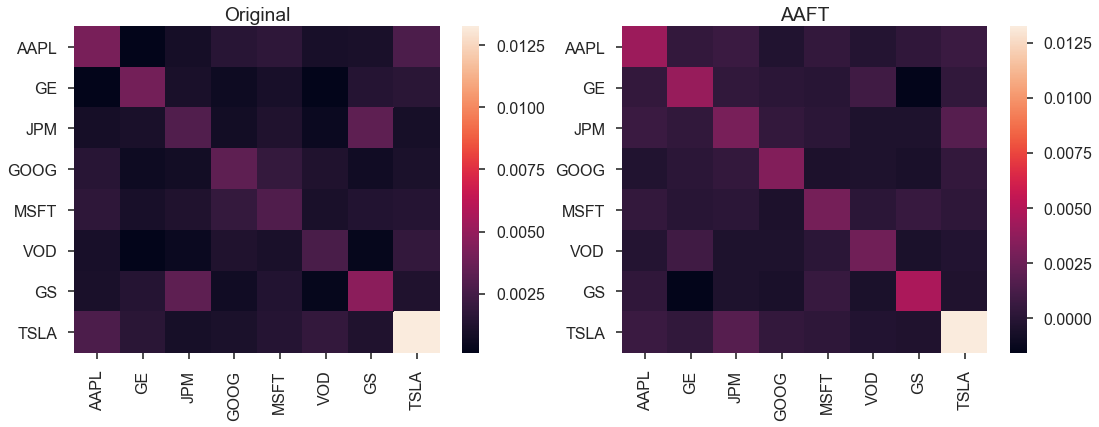

In [13]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(np.cov(returns.values.T), ax=axes[0])
axes[0].set_title("Original")
axes[0].set_xticklabels(returns.columns, rotation=90)
axes[0].set_yticklabels(returns.columns, rotation=0)
sns.heatmap(np.cov(returns_gen.T), ax=axes[1])
axes[1].set_title("AAFT")
axes[1].set_xticklabels(returns.columns, rotation=90)
axes[1].set_yticklabels(returns.columns, rotation=0);

### Vector Autoregressive Process (VAR)

We are interested in modeling a $T \times K$ multivariate time series $Y$,
where $T$ denotes the number of observations and $K$ the number of variables.
One way of estimating relationships between the time series and their lagged values is
the **Vector Autoregression (VAR) Process**:

\begin{aligned}
    Y_{t}   &= A_{1} Y_{t-1} + A_{2} + Y_{t-2} + \ldots + A_{p} + Y_{t-p} + u_{t}\\
            &= \sum_{i=1}^{p} A_{i} Y_{t-i} + u_{t}\\
            & u_{t} \sim \text{Normal}(0, \Sigma_{u})
\end{aligned}

where $A_{i} \in R^{K \times K}$ a coefficient matrix.

In [14]:
# VAR model
var = VAR(returns.values)
# optimal order
order = var.select_order(5)['aic']
# fit model
model = var.fit(order)
# Simulation
returns_gen = var_util.varsim(model.coefs, model.intercept, model.sigma_u, steps=len(returns.values))

                 VAR Order Selection                 
           aic          bic          fpe         hqic
-----------------------------------------------------
0       -47.50       -47.45    2.350e-21       -47.48
1      -65.14*      -64.69*   5.125e-29*      -64.97*
2       -65.14       -64.28    5.153e-29       -64.80
3       -65.12       -63.86    5.217e-29       -64.64
4       -65.06       -63.40    5.550e-29       -64.42
5       -65.03       -62.96    5.715e-29       -64.23
* Minimum



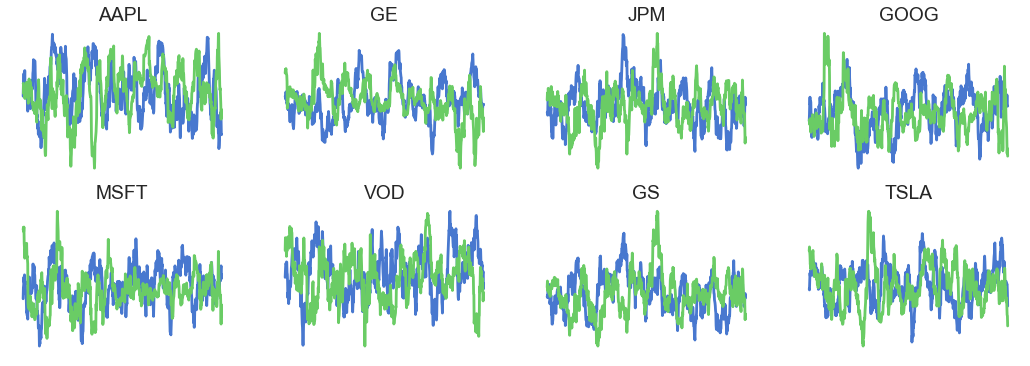

In [15]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(returns.shape[1] / 2), figsize=(18.0, 6.0))
for j, (ax, ts) in enumerate(zip(axes.flatten(), returns_gen.T)):
    ax.plot(ts, label="VAR")
    ax.plot(returns.values[:, j], label="Original")
    ax.set_title(returns.columns[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

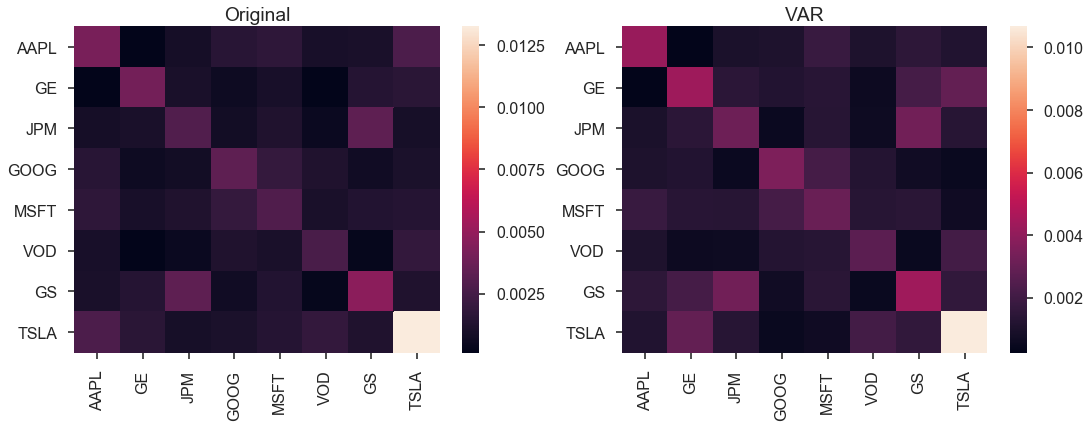

In [16]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(np.cov(returns.values.T), ax=axes[0])
axes[0].set_title("Original")
axes[0].set_xticklabels(returns.columns, rotation=90)
axes[0].set_yticklabels(returns.columns, rotation=0)
sns.heatmap(np.cov(returns_gen.T), ax=axes[1])
axes[1].set_title("VAR")
axes[1].set_xticklabels(returns.columns, rotation=90)
axes[1].set_yticklabels(returns.columns, rotation=0);